**BVM Hands-On Tutorial (Part 1/2)**

In this tutorial we will set up the foundations to load and augment data, create a fully-convolutional network, and train it to solve multi-class segmentation problems in medical application.

Let's first add all imports and mount the Google drive for data storage:

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import ConstantPad3d as Pad
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from google.colab import drive
import tarfile

drive.mount('/content/drive')

If run for the first time, you need to extract the data on the Google drive:

In [0]:
tar = tarfile.open(name='/content/drive/My Drive/Task02_Heart.tar', mode='r')
tar.extractall()
tar.close()

Here are some lines of code just needed later for visualisation:

In [0]:
%%capture

# Custom plot function
def visualise_sample(axs, sample, result, is_training, every_epoch, z_slice):
  """Imshow first sample of batch"""
  offset = 0
  phase = 'training'
  if not is_training:
    phase = 'validation'
    offset = 3    
  axs[epoch//every_epoch][0 + offset].imshow(sample['image'].detach().cpu().numpy()[0, 0, z_slice, :, :])
  axs[epoch//every_epoch][0 + offset].set_title('sample ' + phase + ' image')
  axs[epoch//every_epoch][0 + offset].grid(False)
  axs[epoch//every_epoch][1 + offset].imshow(sample['label'].cpu().numpy()[0, 0, z_slice, :, :])
  axs[epoch//every_epoch][1 + offset].set_title('sample ' + phase + ' label')
  axs[epoch//every_epoch][1 + offset].grid(False)
  axs[epoch//every_epoch][2 + offset].imshow((result.detach().cpu().numpy()>0.5).astype(np.float)[0, 0, z_slice, :, :])
  axs[epoch//every_epoch][2 + offset].set_title('sample ' + phase + ' prediction')
  axs[epoch//every_epoch][2 + offset].grid(False)
  return axs

Pytorch provides utility classes for data loading. There are:

1.   Dataset - Specify how to load a data entity (item[0]=case1.nii.gz, item[1]=case3.nii.gz, ...)
2.   Datasampler - Specify a sampling strategy (sequential, random, subsets, ...)
3.   Dataloader - Batch up the samples for training

In our custom dataset we can define from where to load the files, how to convert them into torch tensors:

In [0]:
class MSD02HeartDataset(Dataset):
  """Dataset MSD Task_02 Heart: Data access on GDrive and conversion to torch"""

  def __init__(self, training_phase=True, transforms=[]):
    # Only ids with ground truth data
    if training_phase:
      self.ids = [3, 4, 5, 7, 9, 10, 11, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 29, 30]  # Training ids
      self.pad0 = [0, 10, 5, 0, 15, 5, 5, 5, 20, 5, 4, 15, 10, 15, 10, 10, 5, 5, 11, 10]
      self.pad1 = [0, 10, 5, 0, 15, 5, 5, 5, 20, 5, 4, 15, 10, 15, 10, 10, 5, 5, 10, 10]
    else:
      self.ids = [2, 8]  # Test ids ...

    self._transforms = Compose(transforms)

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, item):
    assert 0 <= item < len(self.ids), 'Data index not in valid range.'
    
    result = {'pad0': self.pad0[item],
              'pad1': self.pad1[item]}

    item = self.ids[item]

    fn_image = '/content/Task02_Heart/imagesTr/la_{:03}.nii.gz'.format(item)
    fn_label = '/content/Task02_Heart/labelsTr/la_{:03}.nii.gz'.format(item)

    result['image'] = nib.load(fn_image).get_data()[:, :, :, np.newaxis]
    result['label'] = nib.load(fn_label).get_data()[:, :, :, np.newaxis]

    # Numpy order: x, y, z, c
    result['image'] = torch.from_numpy(result['image']).float()
    result['label'] = torch.from_numpy(result['label']).long()

    # Torch order: c, z ,y ,x
    result['image'] = result['image'].permute(3, 2, 1, 0)
    result['label'] = result['label'].permute(3, 2, 1, 0)

    # Pytorch works on 5D tensors for spatial data
    result['image'] = result['image'].unsqueeze(0)  # b, c, z, y, x
    result['label'] = result['label'].unsqueeze(0)
    result = self._transforms(result)
    result['image'] = result['image'].squeeze(0)  # c, z, y, x
    result['label'] = result['label'].squeeze(0)

    return result  # batch dimension will be added later with the dataloader

Any data augmentation can be defined with Transforms, that do not follow any code blueprint. They only need to implement the `__call__` function.

These classes can then be put in a plausible sequential order (remember, e.g., geometric transforms are not commutable!) to process the dataset items before the sampling takes places. For concatenation of all transforms, `torchvision.transforms.Compose` is being used in the dataset above.

We define some transformations to bring the different sized images into a common voxel size, downscale them for less computational resource demand, and provide sample augmentation via the grid sampler.

In [0]:
class ZeroPad(object):
  """Pad tensors with zeros in z-direction"""
  
  def __call__(self, sample):
    pad_front = int(sample['pad0']) + 15
    pad_back = int(sample['pad1']) + 15
    pad = Pad((0, 0, 0, 0, pad_front, pad_back), 0)
    sample['image'] = pad(sample['image'])
    sample['label'] = pad(sample['label'])
    return sample


class ToCuda(object):
  def __call__(self, sample):
    sample['image'] = sample['image'].cuda()
    sample['label'] = sample['label'].cuda()
    return sample

  
class Scale(object):
  """Scale tensors spatially."""

  def __init__(self, width=1, height=1, depth=1):
    assert width or height or depth
    self.width = width
    self.height = height
    self.depth = depth

  def __call__(self, sample):
    sample['image'] = F.interpolate(
      sample['image'],
      scale_factor=(self.depth, self.height, self.width)
    )

    sample['label'] = F.interpolate(
      sample['label'].float(),
      scale_factor=(self.depth, self.height, self.width),
      mode='nearest'
    ).long()

    return sample
  

class AugmentAffine(object):
  """Author: Mattias P Heinrich"""
    
  def __init__(self, strength=0.05):
    self.strength = strength
    
  def __call__(self, sample):
    affine_matrix = torch.eye(3,4).unsqueeze(0)
    affine_matrix += torch.randn(sample['image'].size(0), 3, 4) * self.strength

    mgrid = F.affine_grid(affine_matrix, sample['image'].size())

    sample['image'] = F.grid_sample(sample['image'], mgrid, padding_mode='border')
    sample['label'] = F.grid_sample(sample['label'].float(), mgrid, mode='nearest').long()

    return sample

Finally, after definition we need to instantiate the data loading classes.

During this, we create a training and a validation set in a split of 80% vs. 20%:

In [0]:
z_slice = 31    # z slice that shall be plotted later
batch_size = 4  # number of samples per batch

augmentation_training = [ZeroPad(),
                         Scale(.2, .2, .4),
                         AugmentAffine(0.15),
                         ToCuda()]
augmentation_validate = [ZeroPad(),
                         Scale(.2, .2, .4),
                         ToCuda()]

dataset_training = MSD02HeartDataset(training_phase=True,
                                     transforms=augmentation_training)
dataset_validate = MSD02HeartDataset(training_phase=True,
                                     transforms=augmentation_validate)

indices = list(range(len(dataset_training)))  # don't take dataset_training.ids!
split_index = int(len(dataset_training) * 0.8)  # split data 80:20 (training:validation)

sampler_training = SubsetRandomSampler(indices[:split_index])
sampler_validate = SubsetRandomSampler(indices[split_index:])

loader_training = DataLoader(dataset=dataset_training,
                             batch_size=batch_size,
                             sampler=sampler_training)

loader_validate = DataLoader(dataset=dataset_validate,
                             batch_size=batch_size,
                             sampler=sampler_validate)

print('Indices training:', sampler_training.indices)
print('Indices validation:', sampler_validate.indices)

Indices training: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Indices validation: [16, 17, 18, 19]


Let's see how what batches we have.

How does a batch look like?

In [0]:
# Print training batch sample sizes
for sample in loader_training:
  print(sample['image'].size(), sample['label'].size())

torch.Size([4, 1, 64, 64, 64]) torch.Size([4, 1, 64, 64, 64])
torch.Size([4, 1, 64, 64, 64]) torch.Size([4, 1, 64, 64, 64])
torch.Size([4, 1, 64, 64, 64]) torch.Size([4, 1, 64, 64, 64])
torch.Size([4, 1, 64, 64, 64]) torch.Size([4, 1, 64, 64, 64])


Define a proper Unet architecture:

In [0]:
class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.block0 = nn.Sequential(nn.Conv3d(1, 32, 3, padding=1),
                                nn.ReLU(),
                                nn.Conv3d(32, 32, 3, padding=1),
                                nn.ReLU()
                               )
                    
    self.mp01 = nn.MaxPool3d(2, 2)
                    
    self.block1 = nn.Sequential(nn.BatchNorm3d(32),
                                nn.Conv3d(32, 64, 3, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(64),
                                nn.Conv3d(64, 64, 3, padding=1),
                                nn.ReLU()
                               )
                    
    self.mp12 = nn.MaxPool3d(2, 2)
                    
    self.block2 = nn.Sequential(nn.BatchNorm3d(64),
                                nn.Conv3d(64, 128, 3, padding=1),
                                nn.ReLU(),                    
                                nn.BatchNorm3d(128),
                                nn.Conv3d(128, 128, 3, padding=1),
                                nn.ReLU()
                               )

    #self.up23 = nn.Upsample(scale_factor=2, mode='trilinear')
                    
    self.block3 = nn.Sequential(nn.BatchNorm3d(192),
                                nn.Conv3d(192, 128, 3, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(128),
                                nn.Conv3d(128, 64, 3, padding=1),
                                nn.ReLU()
                               )
    
    #self.up34 = nn.Upsample(scale_factor=2, mode='trilinear')
                    
    self.block4 = nn.Sequential(nn.BatchNorm3d(96),
                                nn.Conv3d(96, 64, 3, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(64),
                                nn.Conv3d(64, 32, 3, padding=1),
                                nn.ReLU()
                               )
                    
    self.block5 = nn.Sequential(nn.Conv3d(32, 1, 1),
                                nn.Sigmoid(),
                                #nn.Threshold(0.5, 0)
                               )
    
  def forward(self, inputs):
    output0 = self.block0(inputs)
    output1 = self.mp01(output0)
    output1 = self.block1(output1)
    output2 = self.mp12(output1)
    output2 = self.block2(output2)
    #output3 = self.up23(output2)
    output3 = F.interpolate(output2, scale_factor=2)
    output3 = self.block3(torch.cat([output3, output1], dim=1))
    #output4 = self.up34(output3)
    output4 = F.interpolate(output3, scale_factor=2)
    output4 = self.block4(torch.cat([output4, output0], dim=1))
    return self.block5(output4)
    

Let's set up the experiment. Training of neural networks is an optimzation process.

We thus need, of course, the network model. Further:


1.  Parameters of a model to be optimized: ```net.parameters()```
2.  Optimization criterion: ```nn.BCELoss``` (binary cross-entropy)
3.  Optimizer adapting parameters of (1.) in order to minimize loss (2.): ```torch.optim.Adam```

One hyper-parameter of such gradient-descent optimization is the number of iterations:

1.  Number of epochs: ```n_epochs``` (one epoch: processing all training sample batches once)

In [0]:
# Network instance
net = Unet().cuda()

# What do we need for training?
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.1)

n_epochs = 50

In [0]:
%%capture

# Visualisation of the training every 5 epochs in a comprehensive plot:
every_epoch = 5
fig, axs = plt.subplots(n_epochs//every_epoch,
                        6,
                        sharex=True,
                        sharey=True,
                        figsize=(3*6, 3*n_epochs//every_epoch))

The training procedure based on the training samples itself can be defined as follows.

Note that for validation, we don't need to compute gradients, or backpropagate and update weights! That's what argument `is_training` is good for.

In [0]:
def process_batches(net, loader, optimizer, criterion, axs, z_slice,
                    is_training=True):
  inc_loss = 0
  sum_loss = 0
  
  # Train parameters or fix them for validation?
  net.train(is_training)
  with torch.set_grad_enabled(is_training):
    
    # main loop to process all samples (packed into batches)
    for sample in loader:
      result = net(sample['image'])  # forward run

      loss = criterion(result, sample['label'].float())  # compute BCE loss

      if is_training:
        optimizer.zero_grad()
        loss.backward()   # update gradients according to loss
        optimizer.step()  # update net weights (parameters) according to grads

      sum_loss += float(loss)
      inc_loss += 1
  
  print(sum_loss / inc_loss, end='')
  
  if epoch % 5 == 0:
    axs = visualise_sample(axs, sample, result, is_training, 5, z_slice)

And now: Run the training!

In [0]:
for epoch in range(n_epochs):
  # Scheduler will adapt the learning rate once the step count reaches threshold
  scheduler.step()

  print('Epoch', epoch, end=':')
  
  # Train
  process_batches(net, loader_training, optimizer, criterion, axs, z_slice,
                  is_training=True)
  
  print(end=' | ')

  # Validate
  process_batches(net, loader_validate, optimizer, criterion, axs, z_slice,
                  is_training=False)
  
  print()

Epoch 0:0.7089550495147705 | 0.6799167990684509
Epoch 1:0.5811229944229126 | 0.6531817317008972
Epoch 2:0.48132356256246567 | 0.6163113713264465
Epoch 3:0.40466249734163284 | 0.5345373153686523
Epoch 4:0.33742280304431915 | 0.4209550619125366
Epoch 5:0.2812855914235115 | 0.3148746192455292
Epoch 6:0.23473987355828285 | 0.2342861145734787
Epoch 7:0.19667697325348854 | 0.18173716962337494
Epoch 8:0.16921164095401764 | 0.15938103199005127
Epoch 9:0.14499431848526 | 0.12884163856506348
Epoch 10:0.12597056478261948 | 0.11052753776311874
Epoch 11:0.11191025003790855 | 0.1002429947257042
Epoch 12:0.0995897427201271 | 0.0933428630232811
Epoch 13:0.09206271171569824 | 0.08515091240406036
Epoch 14:0.08288275077939034 | 0.07614386081695557
Epoch 15:0.07561923936009407 | 0.0706561803817749
Epoch 16:0.06804310344159603 | 0.06482669711112976
Epoch 17:0.06364380568265915 | 0.06297686696052551
Epoch 18:0.058640443719923496 | 0.05943421274423599
Epoch 19:0.05740980803966522 | 0.05730443075299263
Epoch 

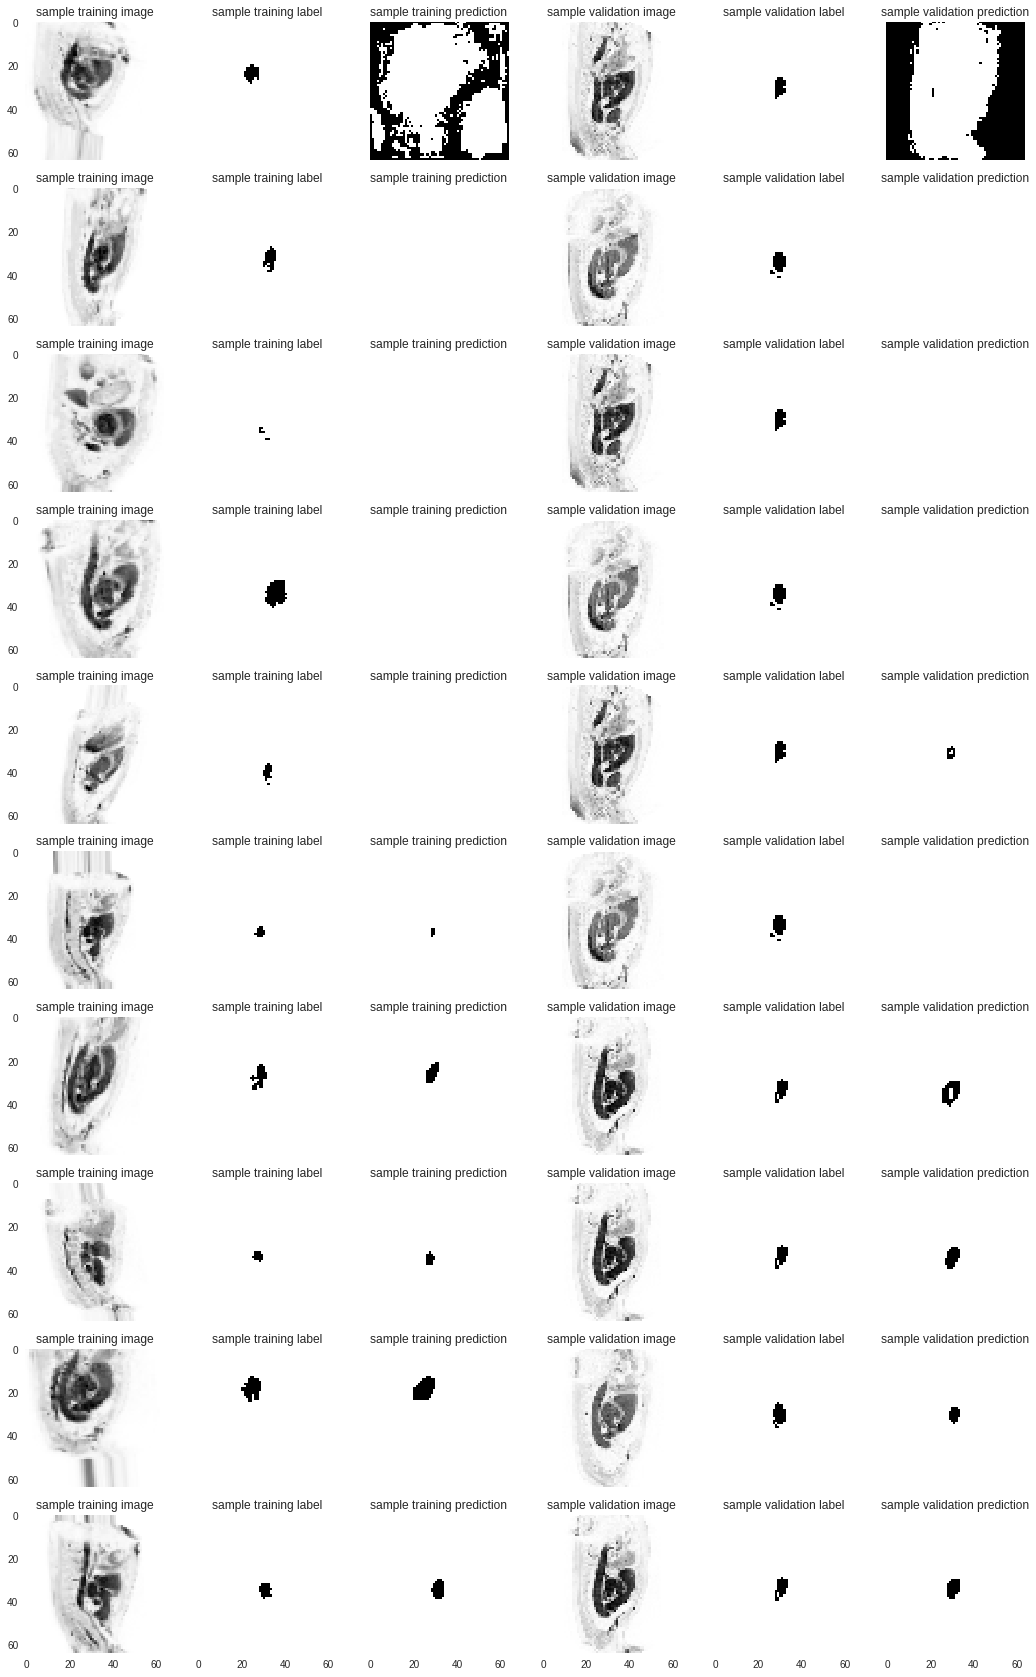

In [0]:
fig